# Model NPZD
Implementation of a NPZD based on the paper 'Internal dynamics of NPZD type ecosystem models'

Model equations:
\begin{align}
\frac{\partial N}{\partial t}&=-J(N,I)P+\phi_{z}Z+\gamma_{m}D \\
\frac{\partial P}{\partial t}&=(J(N,I)-\phi_{P})P-G(\epsilon,g,P)Z \\
\frac{\partial Z}{\partial t}&=(\beta G(\epsilon,g,P)-\phi_{z}-\phi^{*}_{Z}Z)Z\\
\frac{\partial D}{\partial t}&=\phi_{P}P+((1-\beta)G(\epsilon,g,P)+\phi^{*}_{Z}Z)Z-\gamma_{m}D
\end{align}
With:
\begin{align}
J(N,I)&=\mu_{m}\cdot f_{N}(N) \cdot f_{I}(I)=\mu_{m} \cdot \frac{N}{k_{N}+N} \cdot \frac{I}{k_{I}+I} \\
G(\epsilon,g,P)&=\frac{g \epsilon P^{2}}{g+\epsilon P^{2}}
\end{align}


In [17]:
from numpy import *
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [18]:
class NPZD_model():
    def __init__(self,parameters,initial_conditions,model):
        self.I=parameters['I']
        self.beta=parameters['beta']
        self.mum=parameters['mum']
        self.phip=parameters['phip']
        self.phipqua=parameters['phipqua']
        self.epsilon=parameters['epsilon']
        self.gammam=parameters['gammam']
        self.kn=parameters['kn']
        self.ki=parameters['ki']
        self.g=parameters['g']
        self.phiz=parameters['phiz']
        self.phizqua=parameters['phizqua']
        self.model=model
        self.t=parameters['t']
        self.X=initial_conditions
        self.minS=parameters['minS']
        self.maxS=parameters['maxS']
        self.Sstep=parameters['Sstep']

    
    def phyto_growth(self,N):
        return self.mum*(N/(self.kn+N))*(self.I/(self.ki+self.I))

    
    def grazing_growth(self,P):
        return (self.g*self.epsilon*(P**2))/(self.g+self.epsilon*(P**2))
    
    @staticmethod
    
    def llm_model(X,t,self):
        J = self.phyto_growth(X[0])
        G = self.grazing_growth(X[1])
        
        N= -J*X[1]+self.phiz*X[2]+self.gammam*X[3] 
        P=(J-self.phip)*X[1]-G*X[2]
        Z=(self.beta*G-self.phiz)*X[2]
        D=self.phip*X[1]+(1-self.beta)*G*X[2]-self.gammam*X[3]
        return array([N,P,Z,D])
    
    
    @staticmethod


    def lqm_model(X,t,self):
        J = self.phyto_growth(X[0])
        G = self.grazing_growth(X[1])

        N= -J*X[1]+self.phiz*X[2]+self.gammam*X[3]
        P= (J-self.phip)*X[1]-G*X[2]
        Z= (self.beta*G-self.phiz-self.phizqua*X[2])*X[2]
        D= self.phip*X[1]+((1-self.beta)*G+self.phizqua*X[2])*X[2]-self.gammam*X[3]
        return array([N,P,Z,D])
    @staticmethod

    def qqm_model(X,t,self):
        J = self.phyto_growth(X[0])
        G = self.grazing_growth(X[1])        
        
        N=(-J+self.phip)*X[1]+self.phiz*X[2]+self.gammam*X[3]
        P=(J-self.phip-self.phipqua*X[1])*X[1]-G*X[2]
        Z=(self.beta*G-self.phiz-self.phizqua*X[2])*X[2]
        D=self.phipqua*X[1]**2+((1-self.beta)*G+self.phizqua*X[2])*X[2]-self.gammam*X[3]
        return array([N,P,Z,D])
    
    def compute_eq_points(self):
        S_vec=np.arange(self.minS,self.maxS,self.Sstep)
        eqs=np.zeros((len(S_vec),4))
        for i,s in enumerate(S_vec,start=0):
            
            X0=self.X*s/(self.X.sum())
            if (self.model=="LLM"):
                results= odeint(self.llm_model, X0, self.t,args=(self,))
            elif(self.model=="LQM"):
                results= odeint(self.lqm_model, X0, self.t,args=(self,))
            elif(self.model=="QQM"):
                results=odeint(self.qqm_model,X0,self.t,args=(self,))
            eqs[i,0:4]=results[-1,:]
        return eqs
    
    def plot_npzd(self,marker, every, lw):
        colours = ['blue','green','red','gray']
        ixs=np.arange(self.minS,self.maxS,self.Sstep)
        eq_points=self.compute_eq_points()
    
        for i in range(4):
            plt.plot(ixs,eq_points[:,i],label="NPZD"[i]+'_'+self.model,c=colours[i],marker=marker,markevery=every,lw=lw)
    
    
        
    def plot_simulation(self):
        index=[]
        convs = [[],[],[],[]]
        for i in arange(0.01, 35, 0.1):
            S = i
            norm = S/(self.X[0]+self.X[1]+self.X[2]+self.X[3])
            X0=self.X*norm
            if (self.model=="LLM"):
                X= odeint(self.llm_model, X0, self.t,args=(self,))
            elif(self.model=="LQM"):
                X= odeint(self.lqm_model, X0, self.t,args=(self,))
            elif(self.model=="QQM"):
                X=odeint(self.qqm_model,X0,self.t,args=(self,))


            index.append(i)
            convs[0].append(X[-1,0]) 
            convs[1].append(X[-1,1]) 
            convs[2].append(X[-1,2]) 
            convs[3].append(X[-1,3]) 

        plt.figure(figsize=(10, 6))
        plt.title('Equilibrium simulation')
        plt.plot(index,convs[0],label="N_"+self.model)
        plt.plot(index,convs[1],label="P_"+self.model)
        plt.plot(index,convs[2],label="Z_"+self.model)
        plt.plot(index,convs[3],label="D_"+self.model)
        plt.ylim(0,12)

        plt.xlabel('S')
        plt.ylabel('concentration [mol N m^-3]')
        plt.legend()
        plt.show()
        return convs


    

## EQUILIBRIUM POINTS S=35

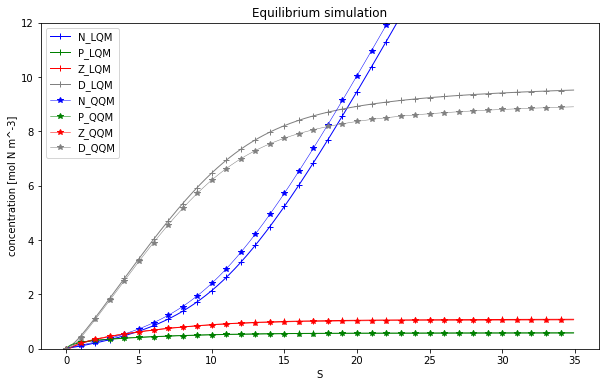

In [19]:
parameters={
"Cref":1.066,    # Growth coefficient of phytoplancton
"c":1,           # Growth coefficient of phytoplancton
"beta":0.925,     # Assimilation coefficient of zooplankton
"alpha":0.256,    # Slope of photoshynthesis vs linght intensity
"mum":0.870,      # Phytoplancton growth rate
"phip":0.04,        # Phytoplancton linear mortality
"phipqua":0.04,     # Phytoplancton quadratic mortality
"epsilon":1.6,      # Grazing encounter rate
"g":1.575,          # Maximum grazing rate
"phiz":0.01,        # Phytoplancton linear mortality
"phizqua":0.34,     # Phytoplancton quadratic mortality
"gammam":0.048,     # Detritus remineralization rate
"kn":0.7,           # Half saturation constant for NO3 uptake
"ki":0.5,           # Half saturation constant for light
"I":8,              # Light initial value
"t":np.linspace(0, 10000,1000000),
"minS":0.01,
"maxS":35,
"Sstep":0.1

# Simulation values

}
plt.figure(figsize=(10, 6))
plt.ylim(0,12)

IC=np.array([1,1,1,1])

typemodel="LQM"
llm_model=NPZD_model(parameters=parameters,initial_conditions=IC,model=typemodel)
convs_llm=llm_model.plot_npzd(marker='+', every=10, lw=1)
typemodel="QQM"
lqm_model=NPZD_model(parameters=parameters,initial_conditions=IC,model=typemodel)
convs_lqm=lqm_model.plot_npzd(marker='*', every=10, lw=0.5)

plt.title('Equilibrium simulation')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')
plt.legend()
plt.show()

## EQUILIBRIUM POINTS S=200

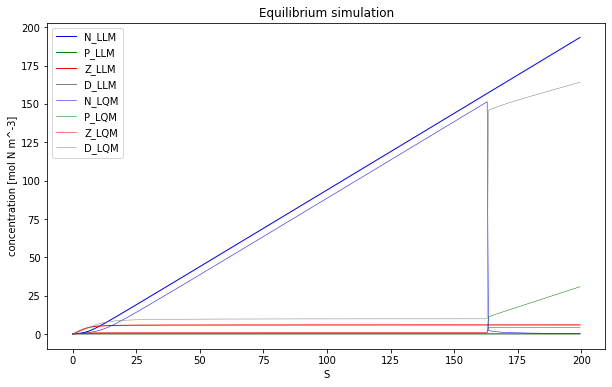

In [74]:
parameters={
"Cref":1.066,    # Growth coefficient of phytoplancton
"c":1,           # Growth coefficient of phytoplancton
"beta":0.925,     # Assimilation coefficient of zooplankton
"alpha":0.256,    # Slope of photoshynthesis vs linght intensity
"mum":0.870,      # Phytoplancton growth rate
"phip":0.04,        # Phytoplancton linear mortality
"phipqua":0.04,     # Phytoplancton quadratic mortality
"epsilon":1.6,      # Grazing encounter rate
"g":1.575,          # Maximum grazing rate
"phiz":0.01,        # Phytoplancton linear mortality
"phizqua":0.34,     # Phytoplancton quadratic mortality
"gammam":0.048,     # Detritus remineralization rate
"kn":0.7,           # Half saturation constant for NO3 uptake
"ki":0.5,           # Half saturation constant for light
"I":8,              # Light initial value
"t":linspace(0, 10000,1000000),
"minS":0.01,
"maxS":200,
"Sstep":0.5

# Simulation values

}
plt.figure(figsize=(10, 6))


typemodel="LLM"
llm_model=NPZD_model(parameters=parameters,initial_conditions=IC,model=typemodel)
convs_llm=llm_model.plot_npzd(marker='', every=15, lw=1)
typemodel="LQM"
lqm_model=NPZD_model(parameters=parameters,initial_conditions=IC,model=typemodel)
convs_lqm=lqm_model.plot_npzd(marker='', every=15, lw=0.5)

plt.title('Equilibrium simulation')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')
plt.legend()
plt.show()

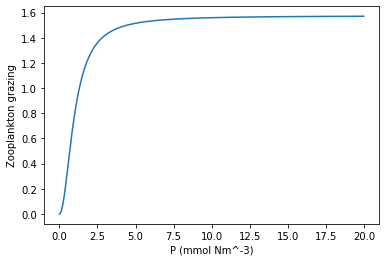

In [8]:
import numpy as np
import matplotlib.pyplot as plt
g=1.575
epsilon=1.6
G=[]
for P in np.arange(0,20,0.01):
    G.append((g*epsilon*P**2)/(g+epsilon*P**2))
plt.plot(np.arange(0,20,0.01),G)
plt.ylabel("Zooplankton grazing")
plt.xlabel("P (mmol Nm^-3)")
plt.savefig("Hooling function")

### Misc

Implementation of a predator prey model

$\begin{cases} \dot{N}=N*(a-b*P) \\ \dot{P}=P*(c*N-d) \end{cases}$

In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [147]:
# Data containers
n_steps = 10000*3
N = np.zeros(n_steps)
P = np.zeros(n_steps)
# Initial values
N[0] = 0.2
P[0] = 0.8

In [148]:
dt = 0.0001

In [149]:
# Params
a = 60
b = 180
c = 80
d = 20

In [151]:
for i in range(n_steps-1):
    dn = N[i]*(a-b*P[i])
    dp = P[i]*(c*N[i]-d)
    if np.isinf(dn):
        print(i)
        break
    N[i+1] = N[i]*(1+dn*dt)
    P[i+1] = P[i]*(1+dp*dt)

First constant: 0.33, second constant: 0.25


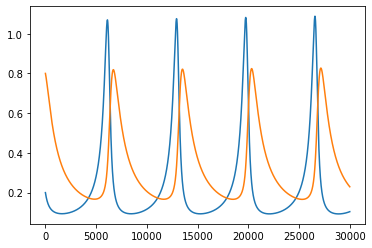

In [156]:
# TODO: Improve visualizations
print(f"First constant: {a/b:.2f}, second constant: {d/c:.2f}")
plt.plot(N[:i])
plt.plot(P[:i])